In [300]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [301]:
field_intensity = np.fromfile('../../data/202101mirror_reconstructed/ring_intensity')
field_phase = np.fromfile('../../data/202101mirror_reconstructed/ring_phase')
M = int(math.sqrt(field_intensity.shape[0]))
print(M)
field_intensity = field_intensity.reshape((M, M))
field_phase = field_phase.reshape((M, M))

1280


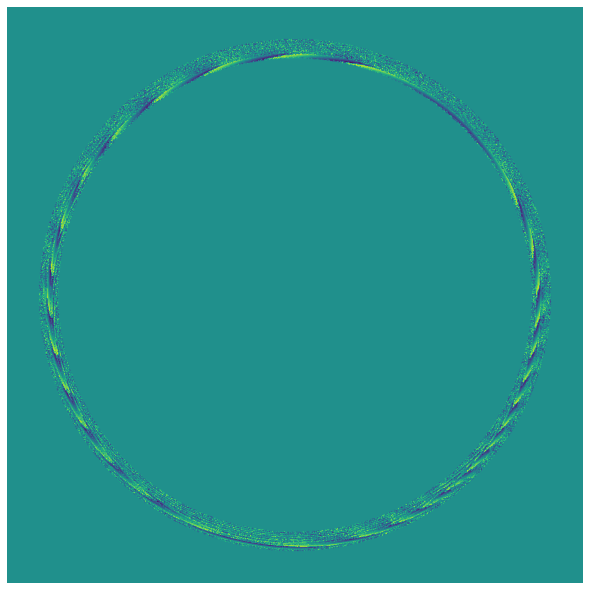

In [302]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.imshow(field_phase)
fig.savefig('../../thesis/chap5/figure/reconstructed_phase_before_unwrap.png')

In [303]:
field_reconstructed = np.sqrt(field_intensity) * np.exp(1.0j * field_phase)

N = 4096
field = np.zeros((N, N), dtype=np.complex128)
field[(N//2-M//2):(N//2+M//2), (N//2-M//2):(N//2+M//2)] = field_reconstructed

In [304]:
def fraunhofer(src, z):
    if z > 0:
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(src)))
    else:
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(src)))

In [305]:
WD = 1902.5e-3
# plt.imshow(np.abs(fraunhofer(field, WD))**2)
focus = fraunhofer(field, WD)

In [306]:
focus_intensity = np.abs(focus)**2

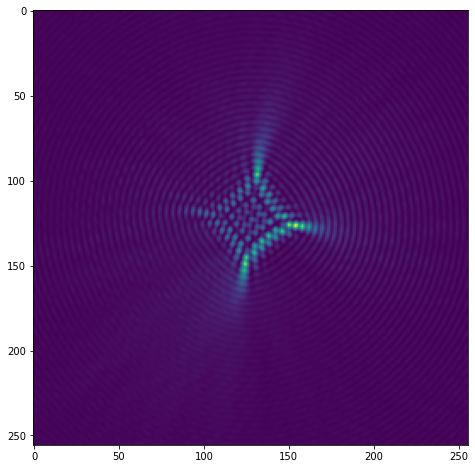

In [307]:
K = 256
center_x = N//2+45
center_y = N//2-20

fig = plt.figure(figsize=(8, 8))
plt.imshow(np.flipud(focus_intensity[(center_x-K//2):(center_x+K//2), (center_y-K//2):(center_y+K//2)]))
fig.savefig('../../thesis/chap5/figure/reconstructed_focus.png')

In [308]:
phase_unwrapped = np.loadtxt('../../data/202101mirror_reconstructed/ring_phase_unwrap.csv', delimiter=',')

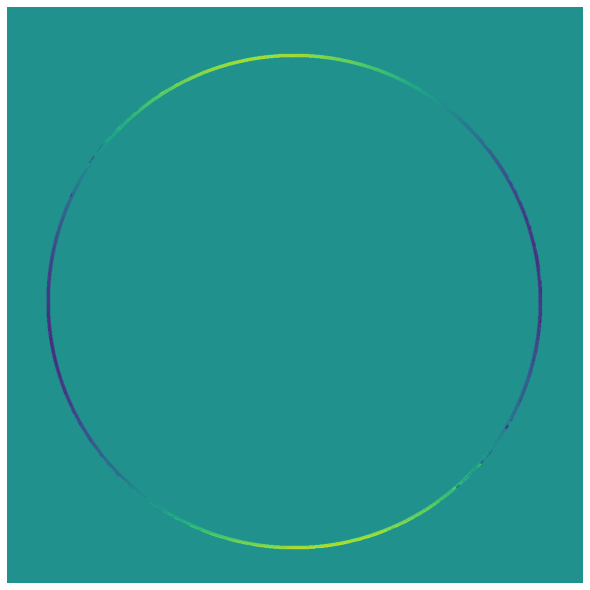

In [309]:
fig = plt.figure(figsize=(8, 8))
plt.axis('off')
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.imshow(phase_unwrapped)
fig.savefig('../../thesis/chap5/figure/reconstructed_phase_unwrapped.png')

In [84]:
phase_unwrapped_polar = np.loadtxt('../../data/202101mirror_reconstructed/ring_phase_unwrap_polar.csv', delimiter=',')

8 360


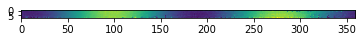

In [86]:
Nr, Nth = phase_unwrapped_polar.shape
print(Nr, Nth)

plt.imshow(phase_unwrapped_polar)

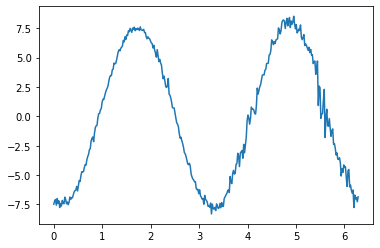

In [310]:
theta = np.linspace(0.0, 2 * math.pi, Nth)
phase_middleline = phase_unwrapped_polar[Nr//2]

phase_middleline_mean = np.mean(phase_middleline)
phase_middleline -= phase_middleline_mean

plt.plot(theta, phase_middleline)

[ 7.67892449 -1.86988254]


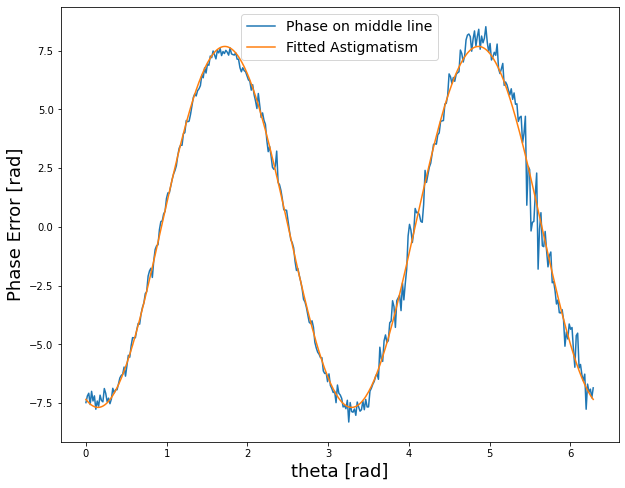

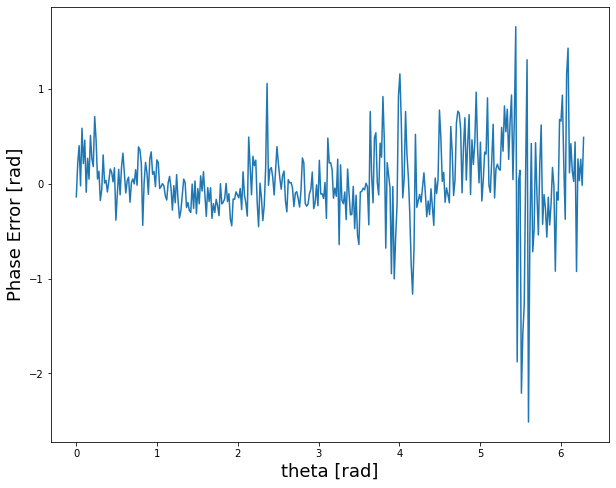

In [311]:
import scipy
import scipy.optimize

parameter_initial = np.array([7.5, -0.6 * math.pi]) # amp, theta_offset


def astigmatism(x, amp, theta_offset):
    return amp * np.sin(2 * x + theta_offset)


parameter_optimal, covariance = scipy.optimize.curve_fit(astigmatism, theta, phase_middleline, p0=parameter_initial)
print(parameter_optimal)

fig = plt.figure(figsize=(10, 8))
plt.plot(theta, phase_middleline, label='Phase on middle line')
plt.plot(theta, astigmatism(theta, *parameter_optimal), label='Fitted Astigmatism')
plt.xlabel('theta [rad]', fontsize=18)
plt.ylabel('Phase Error [rad]', fontsize=18)
plt.legend(fontsize=14)
fig.savefig('../../thesis/chap5/figure/astigmatism_fitted.png')

fig = plt.figure(figsize=(10, 8))
phase_astigmatism_canceled = phase_middleline - astigmatism(theta, *parameter_optimal)
plt.plot(theta, phase_astigmatism_canceled)
plt.xlabel('theta [rad]', fontsize=18)
plt.ylabel('Phase Error [rad]', fontsize=18)
fig.savefig('../../thesis/chap5/figure/astigmatism_canceled.png')

In [312]:
wavelength = 632.8e-9

astigmatism_rad = parameter_optimal[0]
astigmatism_wave = astigmatism_rad / (2.0 * math.pi)
astigmatism_optical_length = astigmatism_wave * wavelength

NA = 29.0e-3 / 1902.5e-3
grazing_angle = NA / 4
roundness_top = astigmatism_optical_length / (2 * grazing_angle)

print(astigmatism_rad)
print(astigmatism_wave)
print(astigmatism_optical_length)
print(NA)
print(grazing_angle)
print(roundness_top * 1.0e+6)

7.6789244863893185
1.2221387896382536
7.733694260830869e-07
0.015243101182654402
0.0038107752956636006
101.47140228434984


In [313]:
for nr in range(Nr):
    phase_middleline = phase_unwrapped_polar[nr]

    phase_middleline_mean = np.mean(phase_middleline)
    phase_middleline -= phase_middleline_mean

    parameter_optimal, covariance = scipy.optimize.curve_fit(astigmatism, theta, phase_middleline, p0=parameter_initial)
    print(parameter_optimal)

[ 3.95694624 -1.87557562]
[ 7.25084994 -1.88620396]
[ 7.50226842 -1.89975094]
[ 7.61404479 -1.89072785]
[ 7.67892449 -1.86988254]
[ 7.54501951 -1.86979768]
[ 7.59763369 -1.85361975]
[ 7.80708174 -1.81003554]


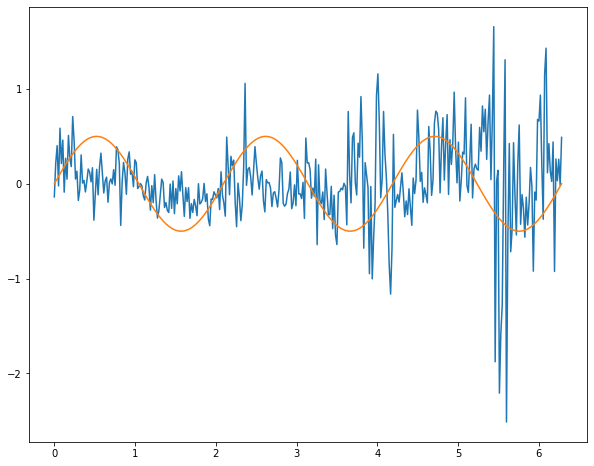

In [314]:
three_top_error = 0.5 * np.sin(3.0 * theta)

plt.figure(figsize=(10, 8))
plt.plot(theta, phase_astigmatism_canceled)
plt.plot(theta, three_top_error)

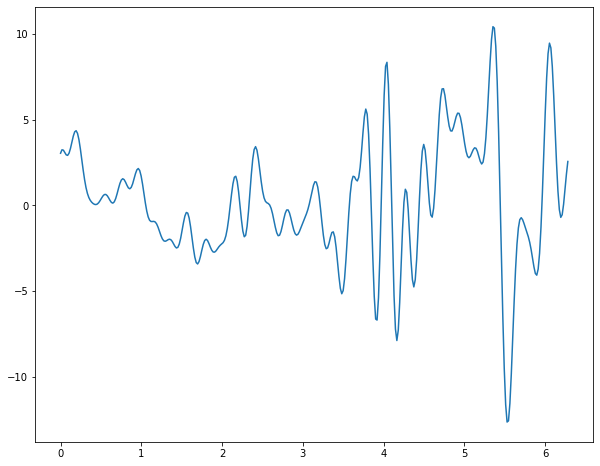

In [317]:
freq = np.fft.fftfreq(Nth, 2.0*math.pi/Nth)
reciprocal = np.fft.fft(phase_astigmatism_canceled)
reciprocal[np.abs(freq) > 5] = 0

phase_lowpass = np.fft.ifft(reciprocal)
plt.figure(figsize=(10, 8))
plt.plot(theta, np.real(phase_lowpass) / (2.0 * math.pi) * wavelength / (2.0 * grazing_angle) * 1.0e+6)
plt.plot(theta, np.real(phase_lowpass) / (2.0 * math.pi) * wavelength / (2.0 * grazing_angle) * 1.0e+6)

In [279]:
roundness_df = pd.read_csv('../../data/roundness_error/roundness_error.csv', header=0, index_col=0)
z = np.array(roundness_df.columns.astype(dtype=int))
theta = np.array(roundness_df.axes[0])
roundness = np.array(roundness_df.values).transpose()

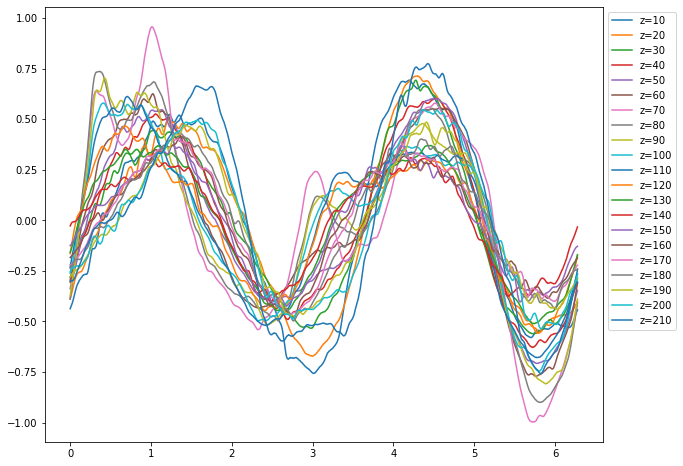

In [295]:
plt.figure(figsize=(10, 8))
for i in range(len(z)):
    plt.plot(theta, roundness[i], label='z=' + str(z[i]))
    
plt.legend(bbox_to_anchor=(1, 1))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

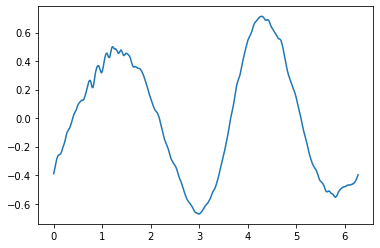

In [282]:
plt.plot(theta, roundness[1])